# Stabilized DG-CG formulation
$ \newcommand{\area}[2]{\left \langle #1, #2 \right \rangle_{\Omega}} $
$ \newcommand{\edge}[2]{\left \langle #1, #2 \right \rangle_{\gamma_i}} $
$ \newcommand{dx}[1]{\frac{\partial #1}{\partial x}} $
$ \newcommand{dy}[1]{\frac{\partial #1}{\partial y}} $ 
$ \newcommand{dt}[1]{\frac{\partial #1}{\partial t}} $

Instead of performing nodal average of DG water elevation, we can solve for continuous momentum directly using the discontinuous momentum solution as in [Clint's and Jennifer's 2002 paper](https://paperpile.com/shared/83RGm3). 

Their momentum formulation is 

$$\area{\dt{u}}{\phi_j} + \area{g \dx{\zeta}}{\phi_j} - \sum_i \edge{g [\zeta]}{\phi_j (n_i)_x} = \area{f_x}{\phi_j}$$
$$\area{\dt{v}}{\phi_j} + \area{g \dy{\zeta}}{\phi_j} - \sum_i \edge{g [\zeta]}{\phi_j (n_i)_y} = \area{f_y}{\phi_j}$$

where 

$$\sum_i \edge{g [\zeta]}{\phi_j (n_i)_x} = \sum_i \edge{g (\zeta^- - \zeta^+)}{\phi_j (n_i)_x}$$

is the stabilization term which penalizes jumps in water elevation.

## Implementation details

To compute the stabilization term, we can loop through the internal edges (as in `internal_edge_hydro.F`), and then add the integral to the RHS of each of the 2 nodes connected to that edge. In the following, we consider interior edge $i$ connected to nodes $k = 1,2$:

$$ 
\begin{align}
\edge{g [\zeta]}{\phi_k n_x}  &= g \int_{\gamma_i} [\zeta] \phi_k n_x \; ds \\
&\approx  g [\bar{\zeta}]  n_x \int_{\gamma_i} \phi_k \; ds \\
&=  g [\bar{\zeta}] n_x \cdot  \frac{1}{2} L_i
\end{align}
$$

where $L_i$ is the edge length of $\gamma_i$. The average of jumps (or jump of averages) of water elevation across the edge can be computed using the DG Gaussian quadrature points. Note that we need to multiply this by 3 in ADCIRC due to the 1/3 term in the lumped quadrature of $\partial u / \partial t$.

```fortran
DO L = NIEDS

    GED = NIEDN(L)
    NM1 = NEDNO(1,GED)
    NM2 = NEDNO(2,GED)

    ZE_IN_TOTAL = 0
    ZE_EX_TOTAL = 0
    
    DO I = 1, NEGP
        ZE_IN = 0
        ZE_EX = 0
        DO K = 1, 3
            ZE_IN = ZE_IN + ZE(K,EL_IN,IRK)*PHI_EDGE(K,GP_IN,LED_IN,pa)
            ZE_EX = ZE_EX + ZE(K,EL_EX,IRK)*PHI_EDGE(K,GP_EX,LED_EX,pa)
        END DO

        ZE_IN_TOTAL = ZE_IN_TOTAL + ZE_IN
        ZE_EX_TOTAL = ZE_EX_TOTAL + ZE_EX
    END DO

    ZE_IN_AVG = ZE_IN_TOTAL / NEGP
    ZE_EX_AVG = ZE_EX_TOTAL / NEGP
    JUMP = ZE_EX_AVG - ZE_IN_AVG

    integral = 3 * G*JUMP * 0.5 * XLEN(GED)
    
    MOM_LV_X(NM1) += integral
    MOM_LV_X(NM2) += integral
    
    MOM_LV_Y(NM1) += integral
    MOM_LV_Y(NM2) += integral

END DO
```

## Tests

In [2]:
from utils_beach import *
from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Quarter Annular

<Figure size 640x480 with 0 Axes>

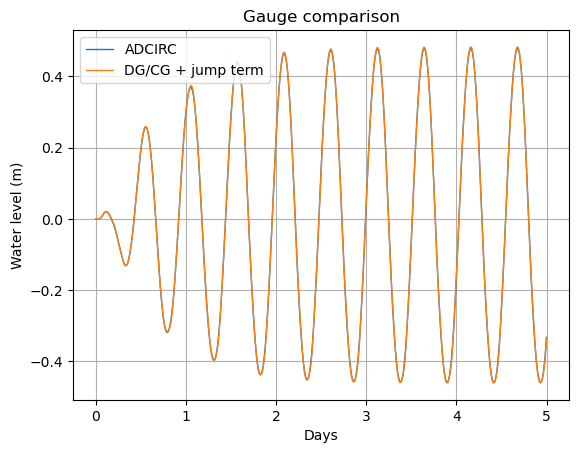

<Figure size 640x480 with 0 Axes>

In [39]:
st = 3
ps = [
    ('QuarterAnnular/fort.61.adc', 'ADCIRC'),
    ('QuarterAnnular/fort.61.stab', 'DG/CG + jump term')
]
f = plot_station(st, ps)

### Lynch & Gray

#### Mesh 1

<Figure size 640x480 with 0 Axes>

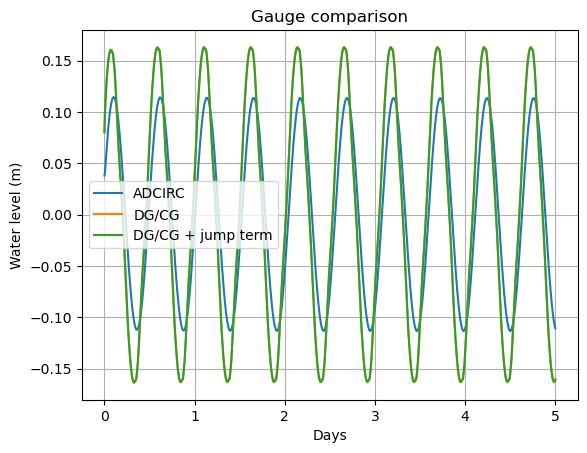

<Figure size 640x480 with 0 Axes>

In [26]:
st = 1
ps = [
    ('LynchGray/Mesh1/fort.61.adc', 'ADCIRC'),
    ('LynchGray/Mesh1/fort.61.coupling', 'DG/CG'),
    ('LynchGray/Mesh1/fort.61.stab', 'DG/CG + jump term')

]
f = plot_station(st, ps)

#### Mesh 2

<Figure size 640x480 with 0 Axes>

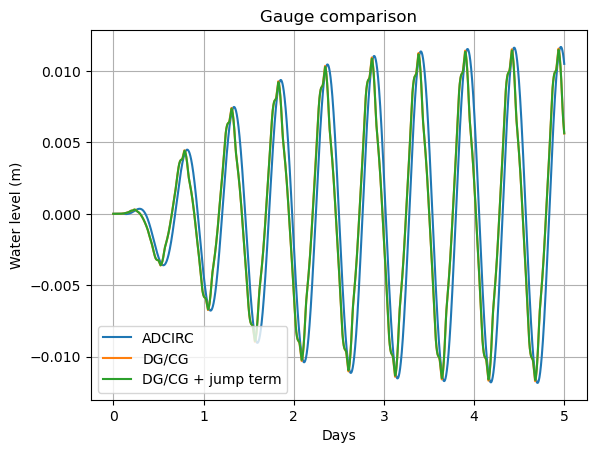

<Figure size 640x480 with 0 Axes>

In [31]:
st = 1
ps = [
    ('LynchGray/Mesh2/fort.61.adc', 'ADCIRC'),
    ('LynchGray/Mesh2/fort.61.coupling', 'DG/CG'),
    ('LynchGray/Mesh2/fort.61.stab', 'DG/CG + jump term')

]
f = plot_station(st, ps)

#### Mesh 3

<Figure size 640x480 with 0 Axes>

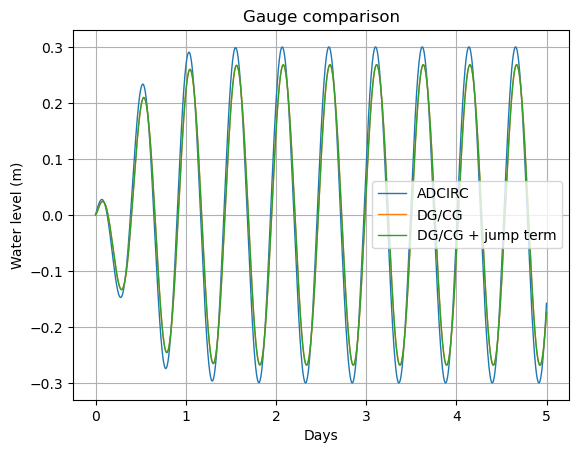

<Figure size 640x480 with 0 Axes>

In [38]:
st = 1
ps = [
    ('LynchGray/Mesh3/fort.61.adc', 'ADCIRC'),
    ('LynchGray/Mesh3/fort.61.coupling', 'DG/CG'),
    ('LynchGray/Mesh3/fort.61.stab', 'DG/CG + jump term')

]
f = plot_station(st, ps)

#### Mesh 4

<Figure size 640x480 with 0 Axes>

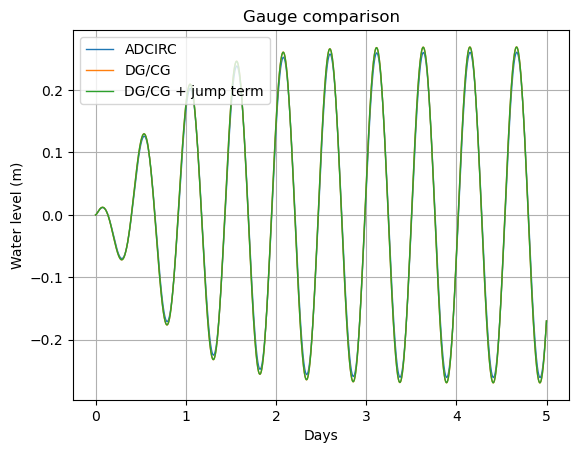

<Figure size 640x480 with 0 Axes>

In [41]:
st = 1
ps = [
    ('LynchGray/Mesh4/fort.61.adc', 'ADCIRC'),
    ('LynchGray/Mesh4/fort.61.coupling', 'DG/CG'),
    ('LynchGray/Mesh4/fort.61.stab', 'DG/CG + jump term')

]
f = plot_station(st, ps)